In [474]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os
import seaborn as sns
from pyscf.scf.uhf import det_ovlp

# Testing in parallel code

In [520]:
filename = "he_vmc_cas_9_nelecas_1_1.hdf5"
f = h5py.File(filename, "r")

In [521]:
f.keys()

<KeysViewHDF5 ['acceptance', 'block', 'configs', 'energycorr', 'energyee', 'energyei', 'energygrad2', 'energyii', 'energyka', 'energykb', 'energyke', 'energytotal', 'energyvh', 'energyvxc', 'excitationsdelta', 'excitationsovlp_ij', 'nconfig']>

In [522]:
def plot_delta_ovlp(filename="abvmc.hdf5", discard = 2, annot=True):
    f = h5py.File(filename, "r")    

    fig, ax = plt.subplots(3, 2, figsize = (12, 15))    
    ovlp_ij_raw=np.array(f['excitationsovlp_ij'])
    delta_ij_raw=np.array(f['excitationsdelta'])
    discard = 2
    ovlp_ij = np.average(ovlp_ij_raw[discard:], axis=0)
    # plt.figure()
    sns.heatmap(ovlp_ij, ax=ax[0, 0], annot=annot)
    ax[0, 0].set_title('Overlap matrix')
    # plt.title('Overlap matrix')

    ovlp_ij_std = np.std(ovlp_ij_raw[discard:], axis=0)
    sns.heatmap(ovlp_ij_std, ax=ax[1, 0], annot=annot)
    ax[1, 0].set_title('Standard deviation of overlap matrix')
    
    filtered_ovlp_ij = copy.deepcopy(ovlp_ij)
    filtered_ovlp_ij[ovlp_ij_std>np.abs(ovlp_ij)] = 0
    sns.heatmap(filtered_ovlp_ij, ax=ax[2, 0], annot=annot)
    ax[2, 0].set_title('Filtered overlap matrix')
    


    delta_ij = np.average(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij, ax=ax[0, 1], annot=annot)
    ax[0, 1].set_title('Delta matrix')
                       
    delta_ij_std = np.std(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij_std, ax=ax[1, 1], annot=annot)
    ax[1, 1].set_title('Standard deviation of delta matrix')
    

    filtered_delta_ij = copy.deepcopy(delta_ij)
    filtered_delta_ij[delta_ij_std>np.abs(delta_ij)] = 0
    sns.heatmap(filtered_delta_ij, ax=ax[2, 1], annot=annot)
    ax[2, 1].set_title('Filtered Delta matrix')
    
    return {'filtered': [filtered_ovlp_ij, filtered_delta_ij], 
            'raw': [ovlp_ij_raw, delta_ij_raw]}
# res = plot_delta_ovlp()

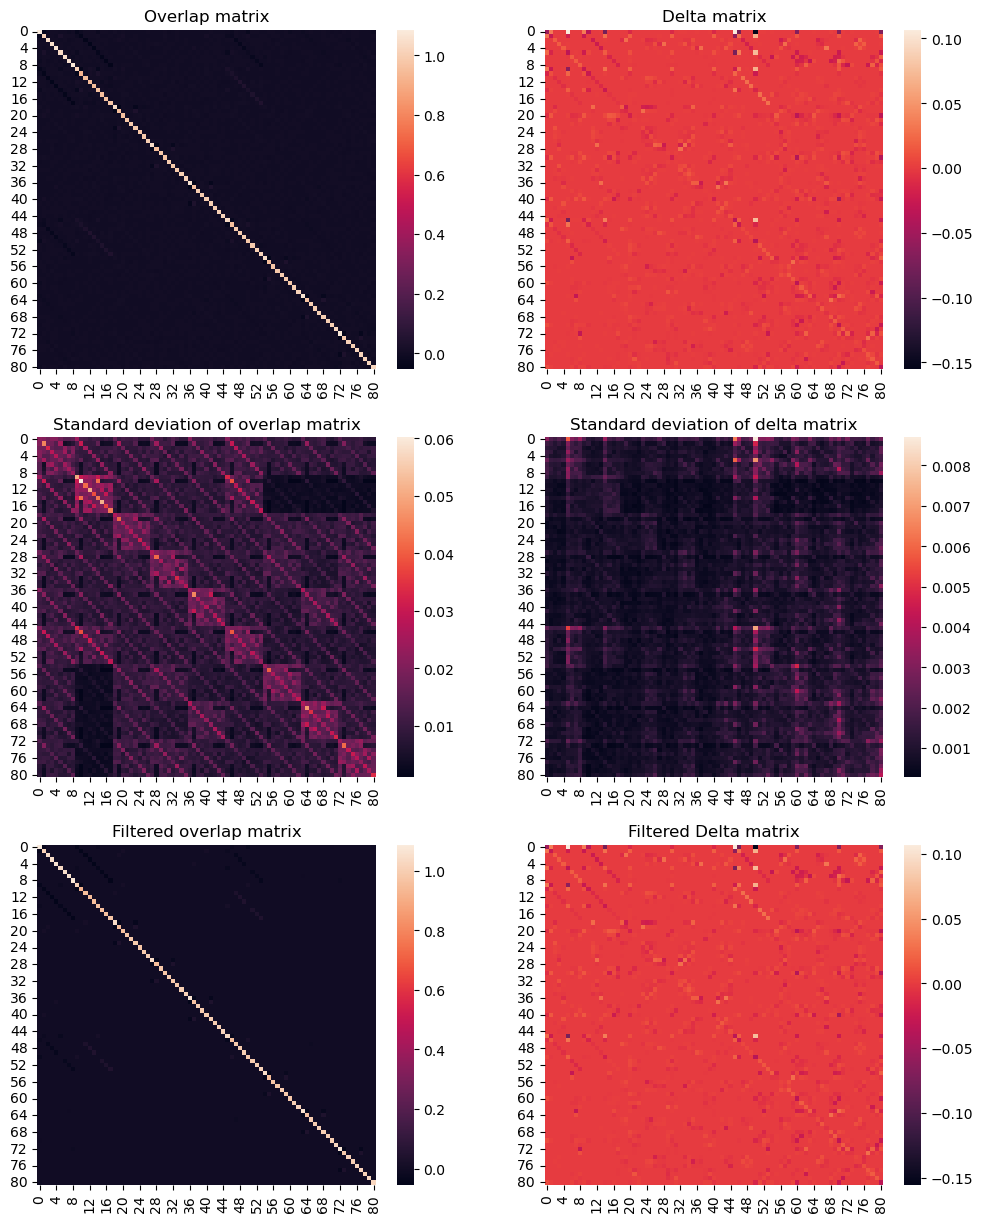

In [523]:
res = plot_delta_ovlp(filename, discard=0, annot=False)
s, delta = res['filtered']
# sinv = np.linalg.inv(s)
# m = np.matmul(sinv, delta)
# e, v = np.linalg.eigh(m)
# (e-e[0]) * 27.211

In [517]:
s, delta = res['raw']
s.shape
# s[:, 0,0]
# delta[:, 0,0]

(157, 81, 81)

In [518]:
def get_h_mf(ci_filename, 
             ncore = (1,1), 
             target_root = 0, 
            compare_functional = 'pbe0'):
    f = h5py.File(ci_filename, "r")    
    ci = np.array(f['ci']['ci'][target_root])
    ncas = np.int32(f['ci']['ncas'])
    nelecas = list(np.array(f['ci']['nelecas']))
    try:
        ncore = list(np.array(f['ci']['ncore']))
    except:
        ncore = np.array(f['ci']['ncore'])
    print('Ncore: ', ncore)
    mo_coeff = np.array(f['ci']['mo_coeff'])
    # mc_mo_energy = np.array(f['ci']['mc_mo_energy'])
    mf_mo_energy = np.array(f['ci']['mf_mo_energy'])
    if compare_functional is not None:
        atom = 'He'
        from pyscf import gto, scf, tools, dft
        mol = gto.M(atom="{} 0. 0. 0.".format(atom), basis="ccpvqz", unit='bohr')    
        mf = mol.UKS()
        mf.xc = 'pbe0'
        mf.kernel()
        xc_mo_energy = mf.mo_energy
    f.close()
    import pyscf
    import determinant_tools

    deters = pyscf.fci.addons.large_ci(ci, ncas, nelecas, tol=-1)
    det = determinant_tools.reformat_binary_dets(deters, ncore=ncore, tol=-1)
    ncore = (ncore-1, ncore-1)
    mf_levels = []
    xc_levels = []
    for d in det:
        c_i, orb_i = d
        orb_up = np.array(orb_i[0])
        orb_up = orb_up[orb_up>ncore[0]]
        orb_dn = np.array(orb_i[1])
        orb_dn = orb_dn[orb_dn>ncore[1]]
        mf_energy = np.sum(mf_mo_energy[0][orb_up]) + np.sum(mf_mo_energy[1][orb_dn])
        if compare_functional is not None:
            xc_energy = np.sum(xc_mo_energy[0][orb_up]) + np.sum(xc_mo_energy[1][orb_dn])  
            xc_levels.append(xc_energy)
        mf_levels.append(mf_energy)
        # print(orb_up, orb_dn, mf_energy)
        # print(orb_i)
    d = {}
    d['mo_energy'] = mf_mo_energy
    if compare_functional is not None:
        d['xc_energy'] = mf_mo_energy
        d['xc_levels'] = xc_levels
    return np.diag(mf_levels), d

def get_sigma(ci_filename, res, compare_functional=None):
    h_mf, d = get_h_mf(ci_filename, target_root = 0, compare_functional=compare_functional)    
    s, delta = res['filtered']
    sigma = np.matmul(np.linalg.inv(s), delta)
    fig, ax = plt.subplots(1, 2, figsize = (10,3))    
    # fig, ax = plt.subplots(3, 2, figsize = (12, 15))    
    sns.heatmap(sigma, ax=ax[0])
    ax[0].set_title('Sigma matrix')
    
    sns.heatmap(h_mf, ax=ax[1])
    ax[1].set_title('Hmf matrix')

    abvmc_eig, abvmc_eigv = np.linalg.eig(h_mf + sigma)
    abvmc_eig = np.sort(abvmc_eig)
    dft_eig = np.sort(np.diag(h_mf))    
    # dft_eig = np.diag(h_mf)
    return abvmc_eig, dft_eig, d
    

Ncore:  0
converged SCF energy = -2.89495479883749  <S^2> = 0  2S+1 = 1
ABVMC LDA PBE0
0.0 0.0 0.0
31.557570236380375 24.978639080540415 28.522959876787635
31.993735610764116 24.978639080540415 28.522959876787635
44.21804595787679 37.90673874548877 42.5190362793448
44.89496347224155 37.90673874548877 42.5190362793448
45.21743240441427 37.90673874548887 42.519036279344974
45.48971121426408 37.90673874548887 42.519036279344974
46.84823995753056 37.90673874548895 42.51903627934498
46.98655005292745 37.90673874548895 42.51903627934498
57.13758871432695 49.95727816108083 57.04591975357527
69.66046143529996 62.88537782602918 71.04199615613244
69.72466412532832 62.88537782602918 71.04199615613244
69.75538949228714 62.885377826029284 71.04199615613261
69.80905875732817 62.885377826029284 71.04199615613261
70.20432761916626 62.88537782602936 71.04199615613261
70.42854623440213 62.88537782602936 71.04199615613261
82.22609582275443 75.81347749097753 85.0380725586896
82.22609582275443 75.813477490

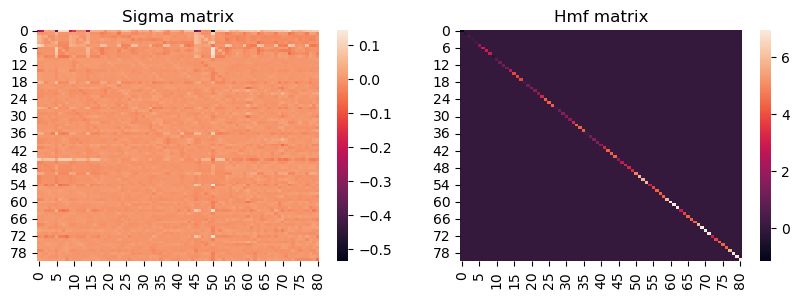

In [519]:
abvmc_eig, dft_eig, d = get_sigma("he-ci.hdf5", res, compare_functional='pbe0')
print('ABVMC', 'LDA', 'PBE0')
for i in range(abvmc_eig.shape[0]):
    abvmc_ref = np.real(abvmc_eig[0])
    dft_ref = dft_eig[0]
    dxc_levels = np.sort(d['xc_levels'])
    xc_ref = dxc_levels[0]
    print(27.211*(np.real(abvmc_eig[i])-abvmc_ref), 27.211*(dft_eig[i]-dft_ref), 27.211*(dxc_levels[i]-xc_ref))